In [ ]:
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_nature

# Import transpile for circuit compilation
from qiskit import transpile

print("qiskit:", qiskit.__version__)
print("aer:", qiskit_aer.__version__)
print("algorithms:", qiskit_algorithms.__version__)
print("nature:", qiskit_nature.__version__)

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_aer.primitives import EstimatorV2 as Estimator

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.optimizers import COBYLA

import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------
# CUSTOM VQE IMPLEMENTATION USING EstimatorV2
# ---------------------------------------------------------
def vqe_estimator_v2(ansatz, operator, optimizer):
    """
    Performs VQE optimization using the EstimatorV2 primitive manually.
    Returns the electronic energy minimum (E_electronic).
    """
    estimator = Estimator()  # qiskit_aer.primitives.EstimatorV2
    x0 = np.zeros(ansatz.num_parameters)

    def energy(params):
        # EstimatorV2.run() MUST be called with a list of "pubs" (tuples) 
        # as a positional argument.
        job = estimator.run(
            [(ansatz, operator, params)]
        )
        result = job.result()
        
        # Accessing the electronic expectation value (E_electronic)
        try:
            # We confirmed this nested access works for your environment: 
            # PrimitiveResult (list) -> PubResult (0) -> data -> evs (0-dim array)
            return result[0].data.evs
        except (AttributeError, IndexError, TypeError) as e:
            # If that fails, re-raise the error for better debugging.
            print(f"Failed to access expectation value via result[0].data.evs. Last error: {e}")
            raise

    # Run the classical optimization loop
    # result.fun here is the minimum electronic energy (E_electronic_min)
    result = optimizer.minimize(fun=energy, x0=x0)
    return result.fun


def calculate_energies(bond_distance):
    """Calculates Exact and VQE ground state energies for a given H2 bond distance."""
    molecule = MoleculeInfo(
        symbols=["H", "H"],
        coords=[(0.0, 0.0, 0.0), (0.0, 0.0, bond_distance)],
        multiplicity=1,     # = 2*spin + 1
        charge=0,
        units=DistanceUnit.ANGSTROM
    )
    
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
    problem = driver.run()
    
    mapper = ParityMapper(num_particles=problem.num_particles)

    # 1. Exact classical solution for reference
    exact_solver = GroundStateEigensolver(mapper, NumPyMinimumEigensolver())
    exact_result = exact_solver.solve(problem)
    
    # Get the Hamiltonian as a qubit operator
    hamiltonian = problem.hamiltonian.second_q_op()
    qubit_hamiltonian = mapper.map(hamiltonian)
    
    # Retrieve the nuclear repulsion energy constant
    nuclear_repulsion_energy = problem.nuclear_repulsion_energy

    # 2. UCCSD Ansatz (Circuit)
    ansatz = UCCSD(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper
        )
    ).decompose() # Initial decomposition

    # Transpile the circuit to the simulator's basis gates 
    # to eliminate unsupported instructions like 'PauliEvolution'.
    ansatz = transpile(ansatz, basis_gates=['sx', 'rz', 'cx', 'id'])


    # 3. Optimizer
    optimizer = COBYLA(maxiter=100)

    # 4. Run custom VQE (returns E_electronic)
    electronic_vqe_energy = vqe_estimator_v2(ansatz, qubit_hamiltonian, optimizer)
    
    # 5. Correction: Convert E_electronic to E_total by adding the nuclear repulsion energy
    total_vqe_energy = electronic_vqe_energy + nuclear_repulsion_energy

    return exact_result.total_energies[0], total_vqe_energy

qiskit: 2.2.3
aer: 0.17.2
algorithms: 0.4.0
nature: 0.7.2



--- Running Calculations (VQE with custom EstimatorV2 loop) ---
Bond = 0.50 Å  | Exact = -1.055160  | VQE = -1.055160
Bond = 0.64 Å  | Exact = -1.128462  | VQE = -1.128462
Bond = 0.79 Å  | Exact = -1.135325  | VQE = -1.135325
Bond = 0.93 Å  | Exact = -1.115433  | VQE = -1.115433
Bond = 1.07 Å  | Exact = -1.085591  | VQE = -1.085591
Bond = 1.21 Å  | Exact = -1.053580  | VQE = -1.053580
Bond = 1.36 Å  | Exact = -1.023650  | VQE = -1.023650
Bond = 1.50 Å  | Exact = -0.998149  | VQE = -0.998149
Bond = 1.64 Å  | Exact = -0.977996  | VQE = -0.977996
Bond = 1.79 Å  | Exact = -0.963051  | VQE = -0.963051
Bond = 1.93 Å  | Exact = -0.952545  | VQE = -0.952544
Bond = 2.07 Å  | Exact = -0.945467  | VQE = -0.945465
Bond = 2.21 Å  | Exact = -0.940849  | VQE = -0.940844
Bond = 2.36 Å  | Exact = -0.937904  | VQE = -0.937903
Bond = 2.50 Å  | Exact = -0.936055  | VQE = -0.936054


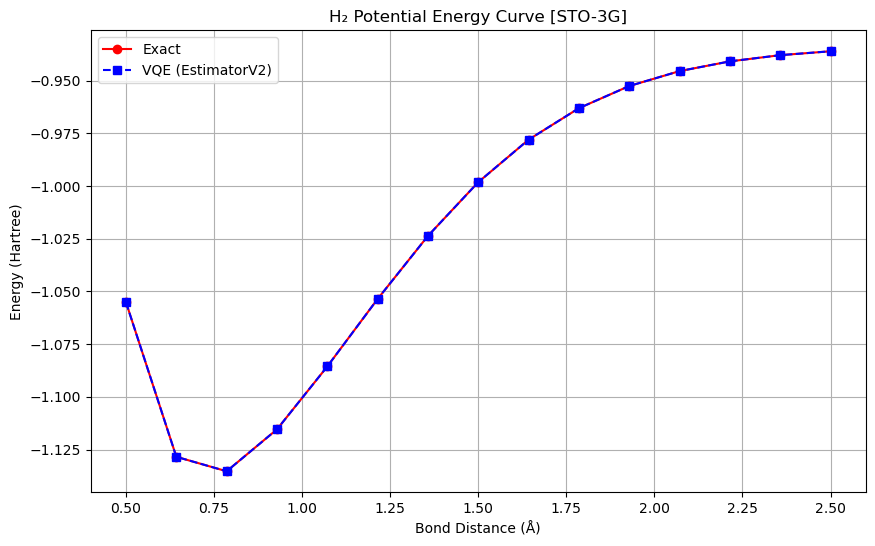

In [2]:

# ---------------------------------------------------------
# SCAN OVER BOND LENGTHS AND PLOT
# ---------------------------------------------------------
# Calculating the Potential Energy Curve (PEC) of H2 [Image of H2 potential energy curve] 
# by calculating the ground state energy across different bond distances.
bond_distances = np.linspace(0.5, 2.5, 15)
exact_energies = []
vqe_energies = []

print("\n--- Running Calculations (VQE with custom EstimatorV2 loop) ---")
for d in bond_distances:
    e_exact, e_vqe = calculate_energies(d)
    exact_energies.append(e_exact)
    vqe_energies.append(e_vqe)
    print(f"Bond = {d:.2f} Å  | Exact = {e_exact:.6f}  | VQE = {e_vqe:.6f}")


plt.figure(figsize=(10,6))
plt.plot(bond_distances, exact_energies, "ro-", label="Exact")
plt.plot(bond_distances, vqe_energies, "bs--", label="VQE (EstimatorV2)")
plt.title('H₂ Potential Energy Curve [STO-3G]')
plt.xlabel("Bond Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.grid(True)
plt.legend()
plt.show()